<a href="https://colab.research.google.com/github/Kevontym/DataScience/blob/main/Brain_Mri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import random

# Path to the train folder on Google Drive
train_path = '/content/drive/MyDrive/BYU_Kaggle/byu-locating-bacterial-flagellar-motors-2025/train'

# List all tomo folders
all_tomo_folders = sorted([f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))])

# Select a random subset of 20 folders
random.seed(42)  # for reproducibility
subset_tomo_folders = random.sample(all_tomo_folders, 20)

# Dictionary to store images from each selected tomo folder
data = {}

# Function to load images from a single tomo folder
def load_images_from_folder(folder_path, target_size=(256,256)):
    images = []
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg')])
    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, target_size)
            img = img.astype(np.float32) / 255.0
            images.append(img)
    return np.array(images)

# Load images from each selected tomo folder
for folder in subset_tomo_folders:
    folder_path = os.path.join(train_path, folder)
    images = load_images_from_folder(folder_path)
    if images.size > 0:
        data[folder] = images
        print(f"Loaded {len(images)} images from folder: {folder}")

# Summary of loaded data
print("Selected tomo folders:", list(data.keys()))

Loaded 300 images from folder: tomo_2cace2
Loaded 800 images from folder: tomo_0a180f
Loaded 300 images from folder: tomo_6c5a26
Loaded 800 images from folder: tomo_63e635
Loaded 800 images from folder: tomo_5b359d
Loaded 500 images from folder: tomo_381add
Loaded 800 images from folder: tomo_2a89bb
Loaded 300 images from folder: tomo_db2a10
Loaded 500 images from folder: tomo_247826
Loaded 300 images from folder: tomo_eb4fd4
Loaded 300 images from folder: tomo_acadd7
Loaded 500 images from folder: tomo_0de3ee
Loaded 300 images from folder: tomo_0d4c9e
Loaded 300 images from folder: tomo_25780f
Loaded 300 images from folder: tomo_57c814
Loaded 300 images from folder: tomo_5f235a
Loaded 500 images from folder: tomo_cad74b
Loaded 800 images from folder: tomo_f36495
Loaded 300 images from folder: tomo_0c2749
Loaded 500 images from folder: tomo_e22370
Selected tomo folders: ['tomo_2cace2', 'tomo_0a180f', 'tomo_6c5a26', 'tomo_63e635', 'tomo_5b359d', 'tomo_381add', 'tomo_2a89bb', 'tomo_db2a1

CNN

In [ ]:
# Convolution: a simple 2D convolution (no padding, stride=1)
def conv2d(image, kernel):
    H, W = image.shape
    kH, kW = kernel.shape
    outH = H - kH + 1
    outW = W - kW + 1
    output = np.zeros((outH, outW))
    for i in range(outH):
        for j in range(outW):
            patch = image[i:i+kH, j:j+kW]
            output[i, j] = np.sum(patch * kernel)
    return output

# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Max pooling operation (pooling size and stride, default 2)
def max_pool(image, size=2, stride=2):
    H, W = image.shape
    outH = (H - size) // stride + 1
    outW = (W - size) // stride + 1
    pooled = np.zeros((outH, outW))
    for i in range(outH):
        for j in range(outW):
            patch = image[i*stride:i*stride+size, j*stride:j*stride+size]
            pooled[i, j] = np.max(patch)
    return pooled


In [ ]:
kernel = np.random.randn(3, 3) * 0.1


Shape of sample image: (256, 256)
Shape after convolution: (254, 254)
Shape after pooling: (127, 127)


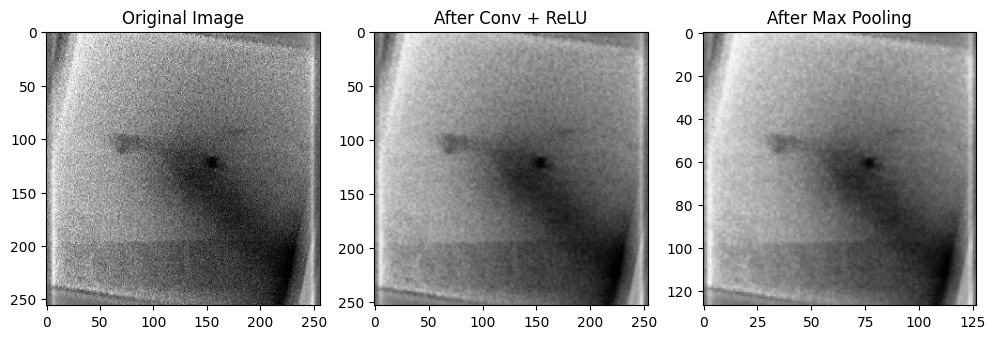

In [ ]:
# Pick one image from one of the loaded tomo folders
# For example, choose the first image from the first folder in our subset:
sample_folder = list(data.keys())[0]
sample_image = data[sample_folder][0]
print(f"Shape of sample image: {sample_image.shape}")  # Should be (256,256)

# Step 1: Convolution
conv_out = conv2d(sample_image, kernel)
print("Shape after convolution:", conv_out.shape)

# Step 2: ReLU Activation
relu_out = relu(conv_out)

# Step 3: Max Pooling
pool_out = max_pool(relu_out, size=2, stride=2)
print("Shape after pooling:", pool_out.shape)

# Visualize results (optional, if matplotlib is available)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("After Conv + ReLU")
plt.imshow(relu_out, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("After Max Pooling")
plt.imshow(pool_out, cmap='gray')

plt.show()

Lets try 3d conv

In [ ]:
import numpy as np

# Suppose we already loaded all slices (each slice is shape (H, W))
# into a NumPy array of shape (num_slices, H, W).
# Let's call it volume_3d for demonstration.

# e.g., from your data dictionary, if 'tomo_003acc' has 50 slices,
# data['tomo_003acc'].shape might be (50, 256, 256).
# We rename it for clarity:
volume_3d = data[sample_folder]  # shape: (D, H, W)

print("3D volume shape:", volume_3d.shape)  # e.g. (50, 256, 256)

3D volume shape: (300, 256, 256)


In [ ]:
def conv3d(volume, kernel):
    """
    volume: shape (D, H, W)
    kernel: shape (kD, kH, kW)
    Returns: convolved volume of shape
             (D - kD + 1, H - kH + 1, W - kW + 1)
    """
    D, H, W = volume.shape
    kD, kH, kW = kernel.shape

    outD = D - kD + 1
    outH = H - kH + 1
    outW = W - kW + 1

    output = np.zeros((outD, outH, outW), dtype=np.float32)

    for d in range(outD):
        for i in range(outH):
            for j in range(outW):
                # Extract the local 3D patch
                patch = volume[d:d+kD, i:i+kH, j:j+kW]
                # Elementwise product and sum
                output[d, i, j] = np.sum(patch * kernel)

    return output

In [ ]:
def relu3d(volume):
    return np.maximum(volume, 0)

In [ ]:
def max_pool3d(volume, size=(2,2,2), stride=(2,2,2)):
    """
    volume: shape (D, H, W)
    size: (pD, pH, pW) pooling window
    stride: (sD, sH, sW) step sizes
    Returns: pooled volume
    """
    D, H, W = volume.shape
    pD, pH, pW = size
    sD, sH, sW = stride

    outD = (D - pD) // sD + 1
    outH = (H - pH) // sH + 1
    outW = (W - pW) // sW + 1

    pooled = np.zeros((outD, outH, outW), dtype=np.float32)

    for d in range(outD):
        for i in range(outH):
            for j in range(outW):
                patch = volume[d*sD : d*sD + pD,
                               i*sH : i*sH + pH,
                               j*sW : j*sW + pW]
                pooled[d, i, j] = np.max(patch)

    return pooled

In [ ]:
# Example: Suppose we pick the first tomo folder and treat its slices as a 3D volume
sample_folder = list(data.keys())[0]
volume_3d = data[sample_folder]  # shape: (D, H, W)

print("Original 3D volume shape:", volume_3d.shape)

# Initialize a random 3D kernel, e.g. (3,3,3)
kernel_3d = np.random.randn(3, 3, 3).astype(np.float32) * 0.1

# Step 1: 3D Convolution
conv_out_3d = conv3d(volume_3d, kernel_3d)
print("After 3D convolution shape:", conv_out_3d.shape)

# Step 2: 3D ReLU
relu_out_3d = relu3d(conv_out_3d)

# Step 3: 3D Max Pooling
pool_out_3d = max_pool3d(relu_out_3d, size=(2,2,2), stride=(2,2,2))
print("After 3D max pooling shape:", pool_out_3d.shape)

Original 3D volume shape: (300, 256, 256)
After 3D convolution shape: (298, 254, 254)
After 3D max pooling shape: (149, 127, 127)


In [ ]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 42.2 MB/s eta 0:00:00


In [ ]:
import SimpleITK as sitk
import numpy as np

In [ ]:
# pool_out_3d is a NumPy array of shape (D, H, W)
# For demonstration, let's just create a random volume
# but in practice, this would be your actual 3D CNN output
pool_out_3d = np.random.rand(50, 128, 128).astype(np.float32)

In [ ]:
# SimpleITK expects the array in [z, y, x] order, which we already have as (D, H, W).
sitk_image = sitk.GetImageFromArray(pool_out_3d)
print(sitk_image)

Image (0xe5ae730)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 1
  Modified Time: 1620
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 0
  UpdateMTime: 0
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [128, 128, 50]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [128, 128, 50]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [128, 128, 50]
  Spacing: [1, 1, 1]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
1 0 0
0 1 0
0 0 1

  PointToIndexMatrix: 
1 0 0
0 1 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0xe5b9530)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
      Reference Count: 1
      Modified Time: 1621
      Debug: Off
      Object Name:

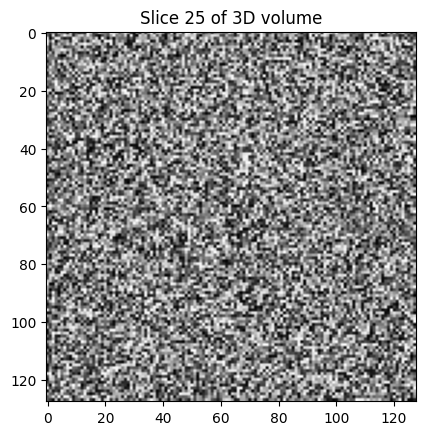

In [ ]:
import matplotlib.pyplot as plt

arr = sitk.GetArrayFromImage(sitk_image)  # shape: (D, H, W)
slice_idx = 25  # pick a slice in the middle
plt.imshow(arr[slice_idx], cmap='gray')
plt.title(f"Slice {slice_idx} of 3D volume")
plt.show()

In [ ]:
pip install dash

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import numpy as np

# Assume your data dictionary 'data' is already loaded
# For example, we pick a volume from one of the tomo folders:
sample_folder = list(data.keys())[0]
volume = data[sample_folder]  # volume shape: (D, H, W)

# Create a Dash app
app = dash.Dash(__name__)

# Define the app layout
app.layout = html.Div([
    html.H1("3D Volume Slice Viewer"),
    dcc.Slider(
        id='slice-slider',
        min=0,
        max=volume.shape[0]-1,
        step=1,
        value=volume.shape[0]//2,
        marks={i: str(i) for i in range(0, volume.shape[0], 5)}
    ),
    dcc.Graph(id='slice-graph')
])

# Callback to update the graph based on the slider value
@app.callback(
    Output('slice-graph', 'figure'),
    [Input('slice-slider', 'value')]
)
def update_slice(slice_index):
    # Extract the corresponding 2D slice from the volume
    slice_img = volume[slice_index, :, :]
    # Create a Plotly figure to display the slice (using a grayscale colormap)
    fig = px.imshow(slice_img, color_continuous_scale='gray')
    fig.update_layout(title=f'Slice {slice_index}', coloraxis_showscale=False)
    return fig

# Run the app
if __name__ == '__main__':
    # Running in Colab will not embed the app inline.
    # Instead, a URL will be printed—open it in a new browser tab.
    app.run_server(debug=True, port=8050)

<IPython.core.display.Javascript object>

In [ ]:
# For testing: Create a synthetic 3D volume
import numpy as np
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

# Create a synthetic 3D volume of shape (D, H, W)
# For example, 30 slices of 128x128 pixels.
# Here, we'll create a volume that has a gradient along the depth axis.
D, H, W = 30, 128, 128
volume = np.zeros((D, H, W), dtype=np.float32)
for d in range(D):
    # Create a simple pattern: increasing brightness with depth
    volume[d] = (d / D) * np.outer(np.linspace(0, 1, H), np.linspace(0, 1, W))

# Create the Dash app
app = dash.Dash(__name__)

# Define the app layout with a slider and graph
app.layout = html.Div([
    html.H1("Synthetic 3D Volume Slice Viewer (Test)"),
    dcc.Slider(
        id='slice-slider',
        min=0,
        max=volume.shape[0]-1,
        step=1,
        value=volume.shape[0]//2,
        marks={i: str(i) for i in range(0, volume.shape[0], 5)}
    ),
    dcc.Graph(id='slice-graph')
])

# Callback to update the graph when the slider changes
@app.callback(
    Output('slice-graph', 'figure'),
    [Input('slice-slider', 'value')]
)
def update_slice(slice_index):
    # Extract the corresponding 2D slice from the synthetic volume
    slice_img = volume[slice_index, :, :]
    # Create a Plotly figure using a grayscale colormap
    fig = px.imshow(slice_img, color_continuous_scale='gray')
    fig.update_layout(title=f'Slice {slice_index}', coloraxis_showscale=False)
    return fig

# Run the app (this will print a URL for you to click)
if __name__ == '__main__':
    app.run_server(debug=True, port=8050)

<IPython.core.display.Javascript object>